In [1]:
import torch
import torch.nn as nn
from torch.nn.modules import loss
import torch.optim as optim

import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.cluster.vq import whiten, kmeans, kmeans2
from scipy.ndimage import uniform_filter1d
import cv2
import time

rng = default_rng(900)

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

In [122]:
# neural network parameters
mb_size = 256 # mini batch dim
h_Q_dim = 512*4 # encoder dim
h_P_dim = 512*4 # decoder dim

lr = 1e-4 # learning rate

# problem dimenc_dimsions
nDrawnSamples = 10 # number of dependent samples to draw during smapling (length of predicted control series)
nPreviousStates = 1 # number of previous states to condition on the steering prediction
dim = 4 # (x, y, yaw, steer)
dimObs = 3*2
dataElements = (nDrawnSamples + nPreviousStates) * dim + dim - 1 + dimObs # steer sample, current pose (3D: x,y,yaw), goal (3D), dimObs (2D x 3)
print(dataElements)

z_dim = 1 # latent dim
X_dim = nDrawnSamples*dim # steering

53


In [123]:
# read in data from .txt file, re-arrange to allow drawing multiple depedent samples

filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/data/ctrlDataPfollowMaze_70kplans'
rawdata = np.genfromtxt(filename, delimiter=',', dtype='d', usecols=[0,1,2,3,7,8,9,10,11,12,13,14,15]) # disregard init

_, pathsIdx = np.unique(rawdata[:,4:], axis=0, return_index=True)
pathsIdx.sort()

pathsLengths = np.roll(pathsIdx, -1) - pathsIdx
pathsLengths[-1] = rawdata.shape[0] - np.sum(pathsLengths[:-1])

validLengthsIdx = np.argwhere(pathsLengths >= nPreviousStates + nDrawnSamples) 
validPlansIdx = pathsIdx[validLengthsIdx]
print(validLengthsIdx.shape)

data = np.zeros(shape=(1, dataElements)) # steering angles, samples (x,y,yaw), goal(x,y,yaw)
tempdata = np.copy(data) # steering angles, samples (x,y,yaw), goal(x,y,yaw)
for ci, i in enumerate(validPlansIdx[:-1].reshape(-1)):
    #rawdata[i:i+pathsLenghts[ci], dim-1] = uniform_filter1d(rawdata[i:i+pathsLenghts[ci], dim-1], size=1, origin=0, mode='nearest', axis=0) # average over steering
    for j in range(pathsLengths[ci] - (nPreviousStates + nDrawnSamples - 1)):
        sample = np.arange(start=j, stop=j + nPreviousStates + nDrawnSamples)

        if np.any(np.abs(np.diff(rawdata[i + sample, 0])) > 0.05) or np.any(np.abs(np.diff(rawdata[i + sample, 1])) > 0.05):
            break # ignore duplicate plans (data generation is not perfect)

        tempdata = np.vstack((tempdata, np.append(rawdata[i + sample, :dim].reshape(1, (nPreviousStates + nDrawnSamples)*dim), rawdata[i, dim:].reshape(1, dim-1+dimObs), axis=1))) 
        if ci % 500 == 0:
            data = np.vstack((data, tempdata[1:]))
            tempdata = np.zeros(shape=(1, dataElements))

rng.shuffle(data) # shuffle data
dataNonscaled = np.copy(data)

# data[:, dim-2::dim] /= np.max(np.abs(data[:, dim-2::dim]),axis=0) # normalize yaw angles to [-1, 1]
# data[:, dim-1::dim] /= np.max(np.abs(data[:, dim-1::dim]),axis=0) # normalzie steering angles to [-1, 1]

pathData = np.copy(data[:, :-dimObs])
obsData = np.copy(data[:, -dimObs:])

numEntries = data.shape[0]
print(data.shape)

(101471, 1)
(1575621, 53)


In [124]:
# change conditions to occupancy grid
def isSampleFree(sample, obs):
    for o in list(range(0,obs.shape[0]//(2*dimW))): # python 2 -> 3: use list(), use //
        isFree = 0
        for d in range(0,sample.shape[0]):
            if (sample[d] < obs[2*dimW*o + d] or sample[d] > obs[2*dimW*o + d + dimW]):
                isFree = 1
                break
        if isFree == 0:
            return 0
    return 1

gridSize = 11
dimW = 3
plotOn = False;

# process data into occupancy grid
conditions = obsData
conditionsOcc = np.zeros([numEntries,gridSize*gridSize])
occGridSamples = np.zeros([gridSize*gridSize, 2])
gridPointsRange = np.linspace(0,1,num=gridSize)

idx = 0;
for i in gridPointsRange:
    for j in gridPointsRange:
        occGridSamples[idx,0] = i
        occGridSamples[idx,1] = j
        idx += 1;

start = time.time();
for j in range(0,numEntries,1):
    dw = 0.1
    gap1 = conditions[j,0:2]
    gap2 = conditions[j,2:4]
    gap3 = conditions[j,4:6]

    obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
    obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
    obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
    obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    
    if j % 5000 == 0:
        print('Iter: {}'.format(j))
        
    occGrid = np.zeros(gridSize*gridSize)
    for i in range(0,gridSize*gridSize):
        occGrid[i] = isSampleFree(occGridSamples[i,:],obs)
    conditionsOcc[j,:] = occGrid
    
end = time.time();
print('Time: ', end-start)

Iter: 0
Iter: 5000
Iter: 10000
Iter: 15000
Iter: 20000
Iter: 25000
Iter: 30000
Iter: 35000
Iter: 40000
Iter: 45000
Iter: 50000
Iter: 55000
Iter: 60000
Iter: 65000
Iter: 70000
Iter: 75000
Iter: 80000
Iter: 85000
Iter: 90000
Iter: 95000
Iter: 100000
Iter: 105000
Iter: 110000
Iter: 115000
Iter: 120000
Iter: 125000
Iter: 130000
Iter: 135000
Iter: 140000
Iter: 145000
Iter: 150000
Iter: 155000
Iter: 160000
Iter: 165000
Iter: 170000
Iter: 175000
Iter: 180000
Iter: 185000
Iter: 190000
Iter: 195000
Iter: 200000
Iter: 205000
Iter: 210000
Iter: 215000
Iter: 220000
Iter: 225000
Iter: 230000
Iter: 235000
Iter: 240000
Iter: 245000
Iter: 250000
Iter: 255000
Iter: 260000
Iter: 265000
Iter: 270000
Iter: 275000
Iter: 280000
Iter: 285000
Iter: 290000
Iter: 295000
Iter: 300000
Iter: 305000
Iter: 310000
Iter: 315000
Iter: 320000
Iter: 325000
Iter: 330000
Iter: 335000
Iter: 340000
Iter: 345000
Iter: 350000
Iter: 355000
Iter: 360000
Iter: 365000
Iter: 370000
Iter: 375000
Iter: 380000
Iter: 385000
Iter: 39000

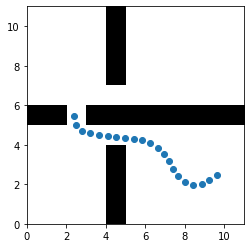

In [102]:
i = np.random.randint(1,numEntries)
plt.imshow(conditionsOcc[i].reshape(gridSize, gridSize), extent=[0, gridSize, 0, gridSize], cmap='gray')
plt.scatter(pathData[i, :-dim:dim] * gridSize, pathData[i, 1:-dim:dim] * gridSize)
plt.show()

In [125]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)

ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

X_train = pathData[0:numTrain, dim * nPreviousStates:-dim+1] # states [x,y,yaw,steer] to predict
X_test = pathData[numTrain:numEntries, dim * nPreviousStates:-dim+1]

numTest = X_test.shape[0]

print(X_train.shape)

(1260496, 40)


In [126]:
# generate conditioning variable

nextStates = pathData[:, nPreviousStates*dim:-dim+1]

prevStatesConditions = pathData[:, :nPreviousStates * dim]
goalStateCondition = pathData[:, -dim+1:]

cs = np.concatenate((prevStatesConditions, goalStateCondition, conditionsOcc), axis=1)

c_dim = cs.shape[1]
c_train = cs[0:numTrain,:]  
c_test = cs[numTrain:numEntries,:]

print(cs.shape)

(1575621, 128)


In [127]:
# define pytorch networks
# based on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/.ipynb_checkpoints/01_Variational_AutoEncoder-checkpoint.ipynb

class Encoder(nn.Module):
    
    def __init__(self, input_dim=X_dim+c_dim, hidden_dim=h_Q_dim, latent_dim=z_dim):
        super(Encoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):

        seq = self.network(x)

        return self.z_mu(seq), self.z_logvar(seq)


class Decoder(nn.Module):
    def __init__(self, latent_dim=z_dim+c_dim, hidden_dim=h_P_dim, output_dim=X_dim):
        super(Decoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        
        return self.network(x)


class NeuralNetwork(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(NeuralNetwork, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(DEVICE)        # sampling epsilon        
        z = mean + torch.exp(0.5 * logvar) * epsilon       # reparameterization trick
        return z

    def forward(self, x, c, encode=True):
        if encode:

            z_mu, z_logvar = self.Encoder(torch.cat((x, c), dim=1))
            z = self.reparameterization(z_mu, z_logvar)

            y = self.Decoder(torch.cat((z, c), dim=1))

            return y, z_mu, z_logvar
        else:
            z = x
            y = self.Decoder(torch.cat((z, c), dim=1))    

            return y


encoder = Encoder()
decoder = Decoder()
network = NeuralNetwork(Encoder=encoder, Decoder=decoder).to(DEVICE)

weight = torch.from_numpy(1 / np.max(np.abs(data[:, dim * nPreviousStates:-dim+1 - 3*2:]),axis=0)).float().to(DEVICE)

def loss_function(x, y, mean, logvar):
    recon_loss = (weight * (x - y) ** 2).mean()
    kl_loss    = 10**-4 * 2 * torch.sum(torch.exp(logvar) + mean.pow(2) - 1. - logvar, dim=1)

    return torch.mean(kl_loss + recon_loss)

optimizer = optim.Adam(network.parameters(), lr=lr)

In [ ]:
# Training
for it in range(200001):
    # randomly generate batches
    batch_elements = [np.random.randint(0,numTrain-1) for n in range(0,mb_size)]

    X_mb = torch.tensor(X_train[batch_elements,:], requires_grad=True, dtype=torch.float32, device=DEVICE)
    c_mb = torch.tensor(c_train[batch_elements,:], requires_grad=True, dtype=torch.float32, device=DEVICE)
    
    optimizer.zero_grad()

    y, z_mu, z_logvar = network(X_mb, c_mb)
    
    loss = loss_function(X_mb, y, z_mu, z_logvar)
    loss.backward()
    optimizer.step()

    if it % 1000 == 0:
        batch_elements = [np.random.randint(0,numTest-1) for n in range(0,mb_size)]

        Xval_mb = torch.tensor(X_test[batch_elements,:], requires_grad=False, dtype=torch.float32, device=DEVICE)
        cval_mb = torch.tensor(c_test[batch_elements,:], requires_grad=False, dtype=torch.float32, device=DEVICE)

        yval, z_muval, z_logvarval = network(Xval_mb, cval_mb)

        valloss = loss_function(Xval_mb, yval, z_muval, z_logvarval)

        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print('VLoss: {:.4} \n'. format(valloss))

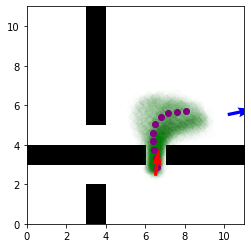

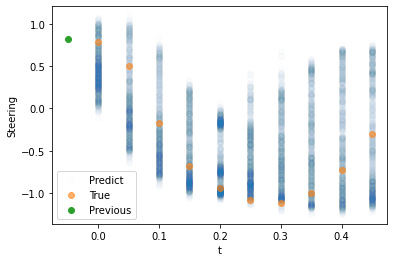

In [140]:
# plot the latent space
num_viz = 800 # number of samples to draw in latent space

vizIdx = np.random.randint(0,numTest-1) # chose a random test scenario
c_sample_seed = c_test[vizIdx,:]
c_sample = torch.from_numpy(np.repeat([c_sample_seed],num_viz,axis=0)).float().to(DEVICE)

y_viz = network(torch.randn(num_viz, z_dim).to(DEVICE), c_sample, encode=False).cpu().detach().numpy() # y_viz is sample in state space, zviz in latent space (3D)
t = np.tile(np.arange(nDrawnSamples), reps=(num_viz, 1)) * 0.05

xPrev = prevStatesConditions[numTrain + vizIdx, ::dim]
yPrev = prevStatesConditions[numTrain + vizIdx, 1::dim]
yawPrev = prevStatesConditions[numTrain + vizIdx, 2::dim]
steerPrev = prevStatesConditions[numTrain + vizIdx, 3::dim]

xNext = nextStates[numTrain + vizIdx, ::dim]
yNext = nextStates[numTrain + vizIdx, 1::dim]
steerNext = nextStates[numTrain + vizIdx, 3::dim]

plt.scatter(y_viz[:num_viz//3,::dim] * gridSize, y_viz[:num_viz//3,1::dim] * gridSize, color='green', s=70, alpha=0.01) # nn samples
plt.scatter(xNext * gridSize, yNext * gridSize, color='purple') # true next poses
plt.quiver(xPrev[-1] * gridSize, yPrev[-1] * gridSize, np.cos(yawPrev[-1]), np.sin(yawPrev[-1]), color='red', scale=8.0, width=0.015) # current pose
plt.quiver(goalStateCondition[numTrain + vizIdx, 0] * gridSize, goalStateCondition[numTrain + vizIdx, 1] * gridSize, np.cos(goalStateCondition[numTrain + vizIdx, 2]), np.sin(goalStateCondition[numTrain + vizIdx, 2]), color="blue", scale=8.0, width=0.015) # goal
plt.imshow(conditionsOcc[numTrain + vizIdx].reshape(gridSize, gridSize), extent=[0, gridSize, 0, gridSize], cmap='gray')
plt.show()

plt.scatter(t, y_viz[:, 3::dim], alpha=0.01)
plt.scatter(t[0], steerNext, alpha = 0.6)
plt.scatter(np.arange(-nPreviousStates, 0) * 0.05, steerPrev)
#plt.ylim([-1.,1.])
plt.legend(['Predict', 'True', 'Previous'])
plt.xlabel('t')
plt.ylabel('Steering')
plt.show()

In [141]:
torch.save(network, "/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/networks/stateAndCtrl_maze_nonscaled_n10.pt")